<a href="https://colab.research.google.com/github/akarsh0913/Practice-Deep-Learning/blob/main/Video_Classification_(UCF101).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [3]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz

In [4]:
!tar xf ucf101_top5.tar.gz

In [5]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [31]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [30]:
import cv2

# Open the video file
video_path = '/content/train/v_CricketShot_g09_c05.avi'  # Replace with the path to your video file
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Release the video file
cap.release()

# Print the total number of frames
print(f"Total frames in the video: {total_frames}")

Total frames in the video: 82


In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
62,v_CricketShot_g16_c07.avi,CricketShot
351,v_Punch_g24_c07.avi,Punch
237,v_PlayingCello_g25_c07.avi,PlayingCello
27,v_CricketShot_g11_c07.avi,CricketShot
401,v_ShavingBeard_g14_c06.avi,ShavingBeard
556,v_TennisSwing_g19_c05.avi,TennisSwing
484,v_TennisSwing_g09_c02.avi,TennisSwing
337,v_Punch_g22_c07.avi,Punch
554,v_TennisSwing_g19_c03.avi,TennisSwing
9,v_CricketShot_g09_c03.avi,CricketShot


In [8]:
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [10]:
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames)

In [14]:
# Using a pre-trained network to extract meaningful features from frames
def build_feature_extractor():
  feature_extractor = keras.applications.InceptionV3(
      weights = "imagenet",
      include_top = False,
      pooling = "avg",
      input_shape = (IMG_SIZE, IMG_SIZE, 3),
  )
  preprocess_input = keras.applications.inception_v3.preprocess_input

  inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
  preprocessed = preprocess_input(inputs)

  outputs = feature_extractor(preprocessed)
  return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

In [12]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 41ms/step


In [22]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [23]:
# Utility for running experiments.
def run_experiment():
    filepath = "/content/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

_, sequence_model = run_experiment()

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.3854 - accuracy: 0.4361
Epoch 1: val_loss improved from inf to 2.07795, saving model to /content/tmp/video_classifier
13/13 [==============================] - 13s 215ms/step - loss: 1.3854 - accuracy: 0.4361 - val_loss: 2.0780 - val_accuracy: 0.3464
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.1401 - accuracy: 0.7470
Epoch 2: val_loss did not improve from 2.07795
13/13 [==============================] - 0s 20ms/step - loss: 1.1401 - accuracy: 0.7470 - val_loss: 2.0979 - val_accuracy: 0.3352
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 1.0144 - accuracy: 0.8145
Epoch 3: val_loss did not improve from 2.07795
13/13 [==============================] - 0s 19ms/step - loss: 1.0144 - accuracy: 0.8145 - val_loss: 2.2947 - val_accuracy: 0.3352
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 0.9011 - accuracy: 0.8530
Epoch 4: val_loss did not improve from 2.077

In [24]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

In [25]:
def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

Test video path: v_TennisSwing_g04_c05.avi
1/1 [==============================] - 0s 23ms/step
  CricketShot: 37.96%
  ShavingBeard: 28.45%
  PlayingCello: 13.99%
  Punch: 13.08%
  TennisSwing:  6.52%



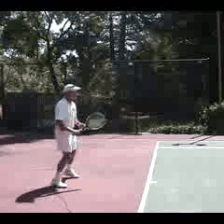

In [28]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=20)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])